In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 1) VAE Model
# -----------------------------
# This class defines the Variational Autoencoder (VAE) model.
# A VAE is a generative model that learns a compressed, probabilistic representation of data.
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim1=512, h_dim2=256, z_dim=20):
        super().__init__()
        # __init__: Initializes the layers for both the encoder and decoder.
        # input_dim is 784 for 28x28 MNIST images flattened.
        # h_dim1 and h_dim2 are dimensions of the hidden layers.
        # z_dim is the dimension of the latent space (20 in this case).

        # Encoder: Maps input data to a latent distribution (mean and log variance).
        self.fc1 = nn.Linear(input_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc_mu = nn.Linear(h_dim2, z_dim)      # Layer to output the mean (mu) of the latent distribution
        self.fc_logvar = nn.Linear(h_dim2, z_dim)  # Layer to output the log variance (logvar) of the latent distribution

        # Decoder: Maps a latent vector back to the original data space (reconstruction).
        self.fc3 = nn.Linear(z_dim, h_dim2)
        self.fc4 = nn.Linear(h_dim2, h_dim1)
        self.fc5 = nn.Linear(h_dim1, input_dim)

    # encode: Takes an input 'x' and passes it through fully connected layers with ReLU activations.
    # It outputs 'mu' (mean) and 'logvar' (log variance) of the latent distribution.
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    # reparameterize: This is the 'reparameterization trick'.
    # It samples a latent vector 'z' from the distribution defined by 'mu' and 'logvar'.
    # This trick allows gradients to flow through the sampling process during training.
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # Calculate standard deviation from log variance
        eps = torch.randn_like(std)   # Sample epsilon from a standard normal distribution
        return mu + std * eps         # Return sampled latent vector z

    # decode: Takes a latent vector 'z' and reconstructs the input data.
    # It uses fully connected layers with ReLU, followed by a final layer and a sigmoid activation
    # to output pixel values between 0 and 1.
    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    # forward: Defines the forward pass of the VAE.
    # It first encodes the input 'x' to get 'mu' and 'logvar',
    # then reparameterizes to get 'z', and finally decodes 'z' to reconstruct the input 'recon'.
    # It returns the reconstruction, 'mu', and 'logvar'.
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# vae_loss: This function calculates the VAE's total loss, which consists of two main parts:
# 1. Reconstruction Loss (Recon): Measures how well the VAE can reconstruct its input.
# 2. KL Divergence (kl): Measures how much the learned latent distribution deviates from a standard normal distribution (regularization).
def vae_loss(recon, x, mu, logvar):
    # Recon (BCE) - Reconstruction loss, typically Binary Cross-Entropy for MNIST-like data.
    # The 'sum' reduction means the loss is summed over all elements in the batch.
    recon_loss = F.binary_cross_entropy(recon, x, reduction="sum")

    # KL divergence to N(0,1) - Regularization term.
    # Encourages the latent space to follow a standard normal distribution.
    # The formula is -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2).
    # Here, log(sigma^2) is logvar, and sigma^2 is exp(logvar).
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Slide 3 refers to a common formulation
    return recon_loss + kl, recon_loss, kl # Return total loss, reconstruction loss, and KL divergence separately

In [ ]:
class new:
  # __init__: This is the constructor method. It's called when an object of the 'new' class is created.
  # It initializes the instance variable 'self.a' to 10.
  def __init__(self):
    self.a = 10

  # __call__: This special method makes instances of the 'new' class callable like functions.
  # When an object (e.g., 'new_object(argument)') is called, this method is executed.
  # It takes an argument 'x' and returns 'x' plus the object's 'self.a' value.
  def __call__(self, x):
    return x+self.a

# This line creates an instance (an object) of the 'new' class and assigns it to the variable 'new'.
# At this point, 'new.a' is 10.
new = new()

# This line calls the 'new' object as if it were a function, passing 5 as the argument 'x'.
# Due to the '__call__' method, it computes 5 + new.a, which is 5 + 10 = 15.
new(5)

15

In [ ]:
# -----------------------------
# 2) Data
# -----------------------------
# transform: This defines a sequence of image transformations to be applied to the dataset.
# transforms.Compose chains multiple transformations together.
transform = transforms.Compose([
    # transforms.ToTensor(): Converts a PIL Image or NumPy ndarray to a torch.FloatTensor.
    # It also scales the image's pixel intensity values from [0, 255] to [0.0, 1.0].
    transforms.ToTensor(),  # [0,1]
])

# train_ds: This loads the MNIST training dataset.
# root='./data': Specifies the directory where the dataset will be stored or looked for.
# train=True: Indicates that the training split of the dataset is desired.
# download=True: If the dataset is not already present, it will be downloaded.
# transform=transform: Applies the defined transformations to each image.
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# train_loader: This creates a DataLoader object, which is an iterator that provides batches of data from the dataset.
# train_ds: The dataset to load data from.
# batch_size=128: Specifies that each iteration will yield a batch of 128 samples.
# shuffle=True: The data will be reshuffled before each epoch to prevent overfitting to the data order.
# num_workers=2: Uses 2 subprocesses for parallel data loading, speeding up the process.
# pin_memory=True: Transfers fetched data Tensors to pinned memory for faster CPU-to-GPU transfer.
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
# image tensor , lable

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.44MB/s]


Epoch 1: loss=175.7906 | recon=167.5488 | kl=8.2418
Epoch 2: loss=126.2836 | recon=110.4257 | kl=15.8579
Epoch 3: loss=115.7870 | recon=98.3349 | kl=17.4521
Epoch 4: loss=111.4603 | recon=93.3917 | kl=18.0686
Epoch 5: loss=109.0270 | recon=90.5807 | kl=18.4463
Epoch 6: loss=107.2880 | recon=88.6410 | kl=18.6470
Epoch 7: loss=106.0270 | recon=87.1520 | kl=18.8750
Epoch 8: loss=105.0418 | recon=86.0588 | kl=18.9829
Epoch 9: loss=104.1584 | recon=85.0660 | kl=19.0924
Epoch 10: loss=103.4684 | recon=84.2876 | kl=19.1808


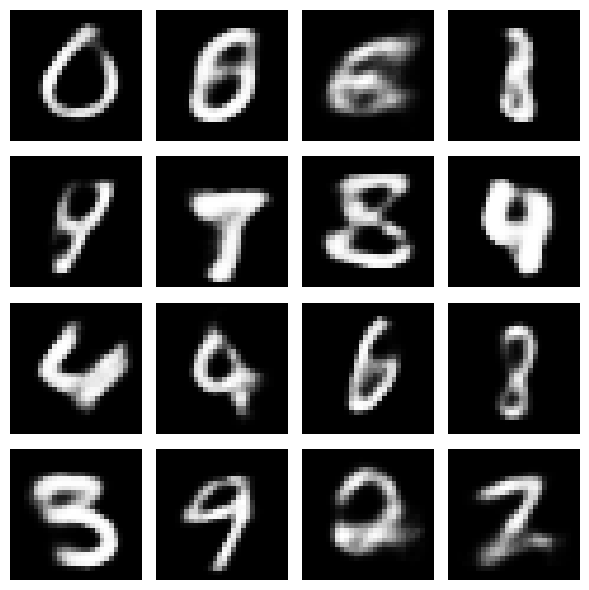

In [ ]:
# -----------------------------
# 3) Train
# -----------------------------
# device: Checks if a CUDA-enabled GPU is available. If yes, it uses 'cuda'; otherwise, it defaults to 'cpu'.
# This allows the model to leverage GPU acceleration for faster training.
device = "cuda" if torch.cuda.is_available() else "cpu"  # cuda / cpu

# vae: Creates an instance of the VAE model with a latent space dimension of 20 (z_dim).
# The .to(device) method moves the model to the selected device (CPU or GPU).
vae = VAE(z_dim=20).to(device)

# opt: Initializes the Adam optimizer. It takes all trainable parameters of the VAE model (vae.parameters())
# and sets the learning rate (lr) to 0.001. Adam is an adaptive learning rate optimization algorithm.
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

# epochs: Defines the number of times the entire dataset will be passed through the network.
epochs = 10  # Increased to 10 for better accuracy

# vae.train(): Sets the model to training mode. This is important for layers like BatchNorm and Dropout
# which behave differently during training and evaluation.
vae.train()

# Training Loop: Iterates over the specified number of epochs.
for epoch in range(1, epochs + 1):
    # Initialize variables to accumulate loss components for the current epoch.
    total_loss = 0.0 # total_loss = total_recon + total_kl
    total_recon = 0.0
    total_kl = 0.0

    # Inner loop: Iterates through batches of data from the train_loader.
    # 'x' contains the image data, '_' is typically for labels (not used directly in VAE).
    for x, _ in train_loader:
        # Move the current batch of images to the selected device (CPU/GPU).
        x = x.to(device)
        # Flatten each 28x28 image into a 1D vector of 784 pixels: (Batch_Size, 784).
        x = x.view(x.size(0), -1)  # flatten: 28*28 >> (B,784)

        # 1. Forward Pass: Computes predicted outputs by passing inputs to the model.
        # Calling 'vae(x)' implicitly invokes the VAE's forward() method,
        # which returns the reconstructed image (recon), latent mean (mu), and latent log variance (logvar).
        recon, mu, logvar = vae(x)

        # 2. Loss Calculation: Evaluates how well the model performed.
        # vae_loss calculates the total loss (Reconstruction loss (BCE) + Regularization loss (KL Divergence)).
        loss, recon_l, kl = vae_loss(recon, x, mu, logvar)

        # 3. Backward Pass: Zero out gradients and compute the gradient of the loss.
        # Clear existing gradients from the previous iteration to prevent accumulation.
        opt.zero_grad()
        # Compute gradients of the loss with respect to all model parameters (Backpropagation).
        loss.backward()

        # 4. Parameter Update: Adjust model weights.
        # Use the optimizer (Adam) to update the weights based on the computed gradients and learning rate.
        opt.step()

        # Accumulate loss components for the epoch.
        total_loss += loss.item()
        total_recon += recon_l.item()
        total_kl += kl.item()

    # Calculate average losses per sample for the current epoch.
    avg_loss = total_loss / len(train_ds)
    avg_recon = total_recon / len(train_ds)
    avg_kl = total_kl / len(train_ds)
    # Print the epoch's training statistics.
    print(f"Epoch {epoch}: loss={avg_loss:.4f} | recon={avg_recon:.4f} | kl={avg_kl:.4f}")


# -----------------------------
# 4) Generate NEW samples: z ~ N(0,1) -> decoder
# -----------------------------
# vae.eval(): Sets the model to evaluation mode. This disables features like Dropout
# and ensures deterministic behavior for inference and generation.
vae.eval()
# torch.inference_mode(): Disables gradient calculation, reducing memory consumption
# and speeding up computations during inference/sampling.
with torch.inference_mode():
    n = 16 # Number of samples to generate
    # Generate 'n' random latent vectors 'z' from a standard normal distribution N(0,1).
    # The dimension of each vector is 20 (z_dim).
    z = torch.randn(n, 20, device=device)       # sample from N(0,1)
    # Use the VAE's decoder to transform the latent vectors 'z' back into image data.
    # The output is then reshaped to (n, 1, 28, 28) to fit image dimensions.
    samples = vae.decode(z).view(n, 1, 28, 28)  # back to image shape

# Plotting the generated samples in a 4x4 grid.
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    # Display each generated image, converting it from a PyTorch tensor to a NumPy array for matplotlib.
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis("off") # Hide axes for cleaner image display
plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.show()

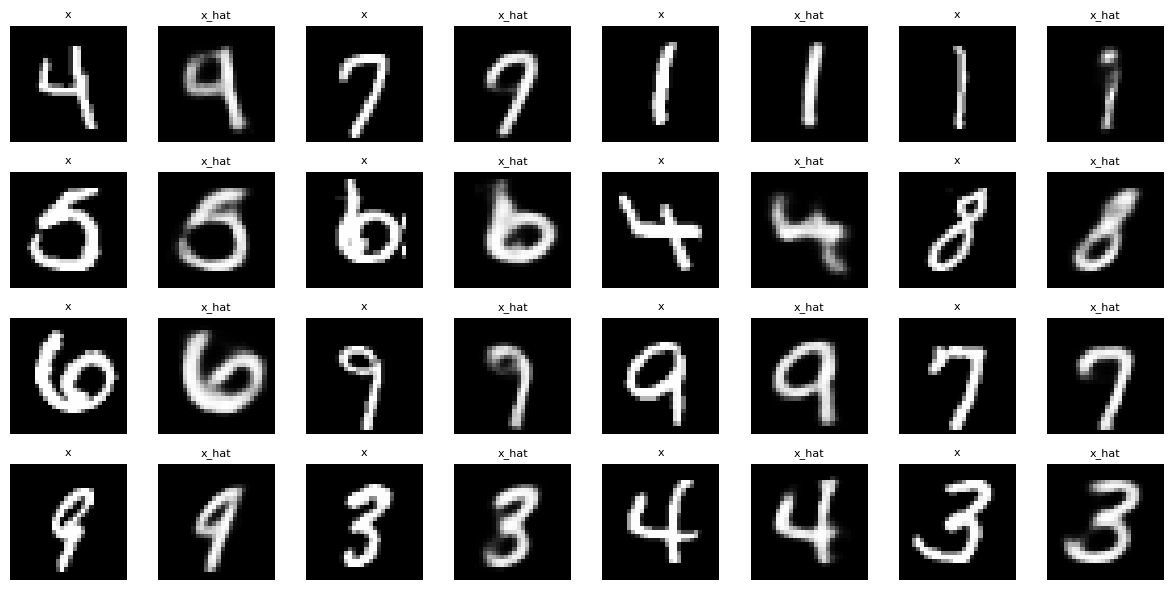

In [ ]:
# -----------------------------
# 5) Reconstructions: x -> recon
# -----------------------------
# torch.inference_mode(): Disables gradient calculation for efficiency during inference.
with torch.inference_mode():
    # Get a batch of images from the training loader.
    x, _ = next(iter(train_loader))
    # Move images to the specified device (CPU/GPU) and select the first 16 for display.
    x = x.to(device)[:16]
    # Flatten the selected images from (batch, channels, height, width) to (batch, flat_dim).
    x_flat = x.view(x.size(0), -1)
    # Pass the flattened images through the VAE to get reconstructions. Ignore mu and logvar.
    recon, _, _ = vae(x_flat)
    # Reshape the reconstructed images back to their original dimensions for display.
    recon = recon.view(16, 1, 28, 28)

# Create a figure and a grid of subplots for displaying original and reconstructed images.
# The grid is 4 rows by 8 columns (4 rows of 2 images each, original + reconstruction).
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
# Iterate through the 16 selected images.
for i in range(16):
    # Display the original image 'x' in an even-numbered column.
    # .squeeze() removes single-dimensional entries from the shape (e.g., channel dimension).
    # .cpu().numpy() converts the PyTorch tensor to a NumPy array for matplotlib.
    axes[i//4, (i%4)*2].imshow(x[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i//4, (i%4)*2].axis("off") # Hide axes for cleaner display.
    axes[i//4, (i%4)*2].set_title("x", fontsize=8) # Set title for the original image.

    # Display the reconstructed image 'recon' in the odd-numbered column next to its original.
    axes[i//4, (i%4)*2 + 1].imshow(recon[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i//4, (i%4)*2 + 1].axis("off") # Hide axes for cleaner display.
    axes[i//4, (i%4)*2 + 1].set_title("x_hat", fontsize=8) # Set title for the reconstructed image.

# Adjust subplot parameters for a tight layout, preventing labels from overlapping.
plt.tight_layout()
# Display the plot.
plt.show()